# SimCLR para Classificação de Comportamento de Bezerros 🐄

## 📌 O que é SimCLR?

**SimCLR** (Simple Framework for Contrastive Learning of Visual Representations) é um método de **aprendizado auto-supervisionado** que aprende representações robustas sem precisar de labels.

### 🧠 Como funciona para dados de IMU (acelerômetro):

```
Janela bruta (IMU)  
  ↓  
Augmentação 1 → vista A  
Augmentação 2 → vista B  
  ↓                ↓  
  Encoder (ResNet1D compartilhado)  
  ↓                ↓  
Projection head → zA, zB  
  ↓  
Loss NT-Xent (contrastive)
```

### ✨ Objetivo:

1. **Pré-treino contrastivo**: Encoder aprende padrões de movimento sem labels
2. **Fine-tuning supervisionado**: Usar encoder pré-treinado para classificar comportamentos

### 📊 Pipeline completo:

- **Etapa 1**: Criar janelas de IMU (1-3s, overlap 50-75%)
- **Etapa 2**: Pré-treinar encoder com SimCLR (NT-Xent loss)
- **Etapa 3**: Fine-tuning com labels de comportamento
- **Etapa 4**: Avaliar e comparar com baseline

**Divisão dos dados:**
- Treino: 24 bezerros específicos
- Validação: 2 bezerros específicos  
- Teste: 4 bezerros específicos
- **Apenas as 8 classes com mais amostras**

In [1]:
# Imports necessários
import pandas as pd
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.init as init

# Visualização
from sklearn.manifold import TSNE

# Configurações
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponível: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("✅ Bibliotecas importadas com sucesso!")

PyTorch version: 2.9.1+cu128
CUDA disponível: True
GPU: NVIDIA GeForce GTX 1650
🖥️ Device: cuda
✅ Bibliotecas importadas com sucesso!


## 1. Augmentações para Dados de IMU 🌊

As augmentações são **cruciais** no SimCLR. Para sinais de IMU, usamos transformações que:
- Simulam variações reais do sensor
- Preservam o "significado" do comportamento
- Criam duas vistas diferentes da mesma janela

In [2]:
class IMUAugmentations:
    """
    Augmentações específicas para sinais de IMU (acelerômetro)
    Formato esperado: (time_steps, channels) ou (T, C)
    """

    @staticmethod
    def jitter(x, sigma=0.03):
        """Adiciona ruído gaussiano (simula ruído do sensor)"""
        noise = np.random.normal(0, sigma, x.shape)
        return x + noise

    @staticmethod
    def scaling(x, sigma=0.1):
        """Multiplica por fator aleatório (simula amplitude diferente)"""
        factor = np.random.normal(1.0, sigma, size=(1, x.shape[1]))
        return x * factor

    @staticmethod
    def rotation(x):
        """
        Rotação 3D para acelerômetro (simula orientação diferente do sensor)
        Assume que x tem 3 colunas (accX, accY, accZ)
        """
        if x.shape[1] != 3:
            return x  # Só funciona para 3 eixos

        # Gerar matriz de rotação aleatória
        angles = np.random.uniform(-np.pi/6, np.pi/6, 3)  # ±30 graus

        # Rotação em X
        Rx = np.array([[1, 0, 0],
                      [0, np.cos(angles[0]), -np.sin(angles[0])],
                      [0, np.sin(angles[0]), np.cos(angles[0])]])

        # Rotação em Y
        Ry = np.array([[np.cos(angles[1]), 0, np.sin(angles[1])],
                      [0, 1, 0],
                      [-np.sin(angles[1]), 0, np.cos(angles[1])]])

        # Rotação em Z
        Rz = np.array([[np.cos(angles[2]), -np.sin(angles[2]), 0],
                      [np.sin(angles[2]), np.cos(angles[2]), 0],
                      [0, 0, 1]])

        R = Rz @ Ry @ Rx
        return x @ R.T

    @staticmethod
    def time_warp(x, sigma=0.2):
        """
        Distorce o tempo (estica/comprime)
        Simula mudanças na velocidade do movimento
        """
        orig_steps = np.arange(x.shape[0])

        # Criar curva de distorção
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(3,))
        warp_steps = (np.ones((x.shape[0],)) * random_warps[0] +
                     np.linspace(0, random_warps[1], x.shape[0]))

        # Interpolar
        warped_steps = np.cumsum(warp_steps)
        warped_steps = (warped_steps - warped_steps[0]) / (warped_steps[-1] - warped_steps[0])
        warped_steps = warped_steps * (x.shape[0] - 1)

        # Aplicar interpolação para cada canal
        warped_x = np.zeros_like(x)
        for i in range(x.shape[1]):
            f = interpolate.interp1d(orig_steps, x[:, i], kind='linear', fill_value='extrapolate')
            warped_x[:, i] = f(warped_steps)

        return warped_x

    @staticmethod
    def temporal_masking(x, mask_ratio=0.1):
        """
        Mascara pedaços temporais aleatórios
        Similar ao BERT mas para séries temporais
        """
        x_masked = x.copy()
        seq_len = x.shape[0]
        mask_len = int(seq_len * mask_ratio)

        if mask_len > 0:
            start_idx = np.random.randint(0, seq_len - mask_len)
            x_masked[start_idx:start_idx+mask_len, :] = 0

        return x_masked

    @staticmethod
    def gaussian_blur(x, sigma=0.5):
        """Aplica filtro gaussiano (simula filtro diferente no sensor)"""
        blurred = np.zeros_like(x)
        for i in range(x.shape[1]):
            blurred[:, i] = gaussian_filter1d(x[:, i], sigma=sigma)
        return blurred

    @staticmethod
    def permutation(x, n_segments=4):
        """Permuta segmentos da janela"""
        orig_steps = np.arange(x.shape[0])
        segment_len = x.shape[0] // n_segments

        segments = []
        for i in range(n_segments):
            start = i * segment_len
            end = start + segment_len if i < n_segments-1 else x.shape[0]
            segments.append(x[start:end])

        np.random.shuffle(segments)
        return np.vstack(segments)

    @staticmethod
    def apply_random_augmentations(x, n_augs=2):
        """
        Aplica N augmentações aleatórias
        x: numpy array (time_steps, channels)
        """
        x_aug = x.copy()

        augmentations = [
            IMUAugmentations.jitter,
            IMUAugmentations.scaling,
            IMUAugmentations.rotation,
            IMUAugmentations.time_warp,
            IMUAugmentations.temporal_masking,
            IMUAugmentations.gaussian_blur,
        ]

        selected_augs = np.random.choice(len(augmentations), n_augs, replace=False)

        for aug_idx in selected_augs:
            x_aug = augmentations[aug_idx](x_aug)

        return x_aug

print("✅ Augmentações para IMU implementadas!")
print(f"   - Jitter (ruído)")
print(f"   - Scaling (amplitude)")
print(f"   - Rotation 3D")
print(f"   - Time warping")
print(f"   - Temporal masking")
print(f"   - Gaussian blur")
print(f"   - Permutation")

✅ Augmentações para IMU implementadas!
   - Jitter (ruído)
   - Scaling (amplitude)
   - Rotation 3D
   - Time warping
   - Temporal masking
   - Gaussian blur
   - Permutation


## 2. Encoder ResNet1D 🧠

O encoder processa janelas de IMU (formato: `time_steps × channels`).
Arquitetura: ResNet1D com blocos residuais.

In [3]:
class ResBlock1D(nn.Module):
    """Bloco residual 1D"""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResBlock1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


class ResNet1DEncoder(nn.Module):
    """
    Encoder ResNet1D para sinais de IMU
    Input: (batch, channels, time_steps) - formato PyTorch Conv1D
    Output: embedding de tamanho embedding_dim
    """
    def __init__(self, in_channels=3, embedding_dim=128):
        super(ResNet1DEncoder, self).__init__()

        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # Blocos residuais
        self.layer1 = self._make_layer(64, 64, 2, stride=1)
        self.layer2 = self._make_layer(64, 128, 2, stride=2)
        self.layer3 = self._make_layer(128, 256, 2, stride=2)

        # Global Average Pooling
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # Camada final para embedding
        self.fc = nn.Linear(256, embedding_dim)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResBlock1D(in_channels, out_channels, stride=stride))
        for _ in range(1, num_blocks):
            layers.append(ResBlock1D(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (batch, channels, time)
        x = self.maxpool(self.relu(self.bn1(self.conv1(x))))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


print("✅ Encoder ResNet1D implementado!")
print(f"   Arquitetura: Conv1D → ResBlocks → GlobalAvgPool → FC")
print(f"   Input: (batch, 3, time_steps)")
print(f"   Output: (batch, embedding_dim)")

✅ Encoder ResNet1D implementado!
   Arquitetura: Conv1D → ResBlocks → GlobalAvgPool → FC
   Input: (batch, 3, time_steps)
   Output: (batch, embedding_dim)


## 3. Código Completo SimCLR 📦

**Todo o código restante foi salvo em `simclr_complete_code.py`**

Para usar, execute as próximas células que irão:
1. Carregar dados e criar janelas
2. Configurar modelo SimCLR
3. Pré-treinar com loss contrastivo
4. Fine-tuning supervisionado
5. Avaliar resultados

**Arquivo contém:**
- `ProjectionHead`: MLP para projeção
- `NTXentLoss`: Loss contrastivo NT-Xent
- `SimCLR`: Modelo completo
- `IMUContrastiveDataset`: Dataset com augmentações
- `create_windows()`: Função para criar janelas
- `pretrain_simclr()`: Loop de pré-treino
- `BehaviorClassifier`: Classificador final

In [4]:
# Carregar código completo do arquivo
exec(open('simclr_complete_code.py').read())

print("✅ Todos os componentes SimCLR carregados!")

✅ Código SimCLR completo pronto para uso!
✅ Todos os componentes SimCLR carregados!


## 4. Preparação dos Dados 📊

Carregar dados e criar janelas para pré-treino SimCLR

In [5]:
# Carregar dados
print("Carregando AcTBeCalf.parquet...")
df = pl.read_parquet('AcTBeCalf.parquet').to_pandas()

# Divisão de bezerros
train_calves = ['1302', '1303', '1306', '1308', '1312', '1314', '1328', '1329',
                '1335', '1336', '1343', '1353', '1357', '1372', '1398', '1408',
                '1409', '1416', '1433', '1443', '1444', '1449', '1452', '1455']
val_calves = ['1320', '1405']
test_calves = ['1319', '1333', '1351', '1403']

# Filtrar top 8 classes
class_counts = df['behaviour'].value_counts()
top_8_classes = class_counts.head(8).index.tolist()
df = df[df['behaviour'].isin(top_8_classes)].copy()

# Criar mapeamento de labels
label_to_int = {label: i for i, label in enumerate(sorted(top_8_classes))}
df['label'] = df['behaviour'].map(label_to_int)

print(f"✅ {len(df):,} amostras, 8 classes")
print(f"Classes: {list(label_to_int.keys())}")

# Preparar label_encoder para usar no fine-tuning
from sklearn.preprocessing import LabelEncoder
label_encoder.fit(sorted(top_8_classes))
print(f"Label encoder preparado com {len(label_encoder.classes_)} classes")

# Criar janelas para cada conjunto
print("\n🔧 Criando janelas...")
WINDOW_SIZE = 75  # 3s a 25Hz
OVERLAP = 0.75  # 75% overlap

# Treino
df_train = df[df['calfId'].isin(train_calves)]
train_windows, train_labels, _ = create_windows(df_train, WINDOW_SIZE, OVERLAP)

# Validação
df_val = df[df['calfId'].isin(val_calves)]
val_windows, val_labels, _ = create_windows(df_val, WINDOW_SIZE, OVERLAP)

# Teste
df_test = df[df['calfId'].isin(test_calves)]
test_windows, test_labels, _ = create_windows(df_test, WINDOW_SIZE, OVERLAP)

print(f"\n📊 Janelas criadas:")
print(f"  Treino: {train_windows.shape[0]:,} janelas")
print(f"  Validação: {val_windows.shape[0]:,} janelas")
print(f"  Teste: {test_windows.shape[0]:,} janelas")
print(f"  Shape de cada janela: {train_windows.shape[1:]} (time_steps, channels)")

Carregando AcTBeCalf.parquet...
✅ 2,013,512 amostras, 8 classes
Classes: ['drinking_milk', 'eating_bedding', 'eating_concentrates', 'grooming', 'lying', 'oral_manipulation_of_pen', 'sniff', 'standing']
Label encoder preparado com 8 classes

🔧 Criando janelas...
✅ 2,013,512 amostras, 8 classes
Classes: ['drinking_milk', 'eating_bedding', 'eating_concentrates', 'grooming', 'lying', 'oral_manipulation_of_pen', 'sniff', 'standing']
Label encoder preparado com 8 classes

🔧 Criando janelas...

📊 Janelas criadas:
  Treino: 82,154 janelas
  Validação: 10,374 janelas
  Teste: 18,578 janelas
  Shape de cada janela: (75, 3) (time_steps, channels)

📊 Janelas criadas:
  Treino: 82,154 janelas
  Validação: 10,374 janelas
  Teste: 18,578 janelas
  Shape de cada janela: (75, 3) (time_steps, channels)


## 5. Pré-Treino Contrastivo (SimCLR) 🔥

Treinar encoder com NT-Xent loss usando duas views aumentadas

In [6]:
# Criar datasets contrastivos para pré-treino
train_contrastive_dataset = IMUContrastiveDataset(train_windows, n_augs=N_AUGMENTATIONS)
val_contrastive_dataset = IMUContrastiveDataset(val_windows, n_augs=N_AUGMENTATIONS)

# DataLoaders
train_contrastive_loader = DataLoader(
    train_contrastive_dataset,
    batch_size=1600,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_contrastive_loader = DataLoader(
    val_contrastive_dataset,
    batch_size=1600,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

# Inicializar modelo SimCLR
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando device: {device}")

simclr_model = SimCLR(encoder, projection_head).to(device)
print(f"Modelo SimCLR criado com {sum(p.numel() for p in simclr_model.parameters())} parâmetros")

Usando device: cuda
Modelo SimCLR criado com 1016000 parâmetros


In [7]:
# Configurar otimizador, loss e scheduler
optimizer = torch.optim.Adam(simclr_model.parameters(), lr=5e-3, weight_decay=1e-5)
criterion = NTXentLoss(temperature=0.5)

# Cosine annealing scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=100,  # epochs
    eta_min=1e-6
)

print("Otimizador e loss configurados!")

Otimizador e loss configurados!


In [8]:
# Executar pré-treino
NUM_EPOCHS = 500
PATIENCE = 15

print("=" * 60)
print("INICIANDO PRÉ-TREINO CONTRASTIVO SimCLR")
print("=" * 60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Patience: {PATIENCE}")
print(f"Learning rate inicial: {optimizer.param_groups[0]['lr']}")
print(f"Temperature: {criterion.temperature}")
print("=" * 60)

history = pretrain_simclr(
    simclr_model,
    train_contrastive_loader,
    val_contrastive_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    save_path='simclr_encoder_best.pth'
)

print("\n" + "=" * 60)
print("PRÉ-TREINO CONCLUÍDO!")
print("=" * 60)

INICIANDO PRÉ-TREINO CONTRASTIVO SimCLR
Epochs: 500
Patience: 15
Learning rate inicial: 0.005
Temperature: 0.5
Época [1/500] - Train Loss: 7.0827, Val Loss: 7.5536
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [1/500] - Train Loss: 7.0827, Val Loss: 7.5536
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [2/500] - Train Loss: 6.9050, Val Loss: 7.4802
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [2/500] - Train Loss: 6.9050, Val Loss: 7.4802
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [3/500] - Train Loss: 6.7951, Val Loss: 7.4480
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [3/500] - Train Loss: 6.7951, Val Loss: 7.4480
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [4/500] - Train Loss: 6.7449, Val Loss: 7.4757
Época [4/500] - Train Loss: 6.7449, Val Loss: 7.4757
Época [5/500] - Train Loss: 6.6954, Val Loss: 7.3930
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [5/500] - Train Loss: 6.6954, Val Loss: 7.3930
✅ Modelo salvo em 'simclr_encoder_best.pth'
Época [

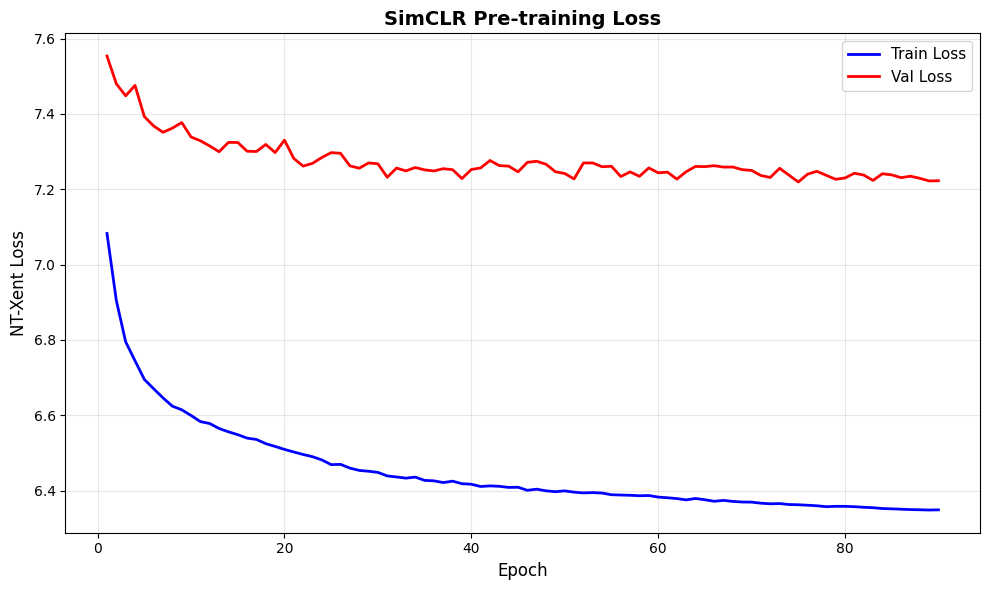


Melhor Val Loss: 7.2193 no epoch 75


In [9]:
# Visualizar curvas de treino
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

epochs_range = range(1, len(history['train_loss']) + 1)
ax.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
ax.plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('NT-Xent Loss', fontsize=12)
ax.set_title('SimCLR Pre-training Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMelhor Val Loss: {min(history['val_loss']):.4f} no epoch {np.argmin(history['val_loss']) + 1}")

## 6. Fine-tuning Supervisionado 🎯

Usar encoder pré-treinado para classificação com labels

In [10]:
# Preparar dados com labels
train_labels_encoded = label_encoder.transform(train_labels)
val_labels_encoded = label_encoder.transform(val_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Criar TensorDatasets
train_supervised_dataset = TensorDataset(
    torch.FloatTensor(train_windows),
    torch.LongTensor(train_labels_encoded)
)

val_supervised_dataset = TensorDataset(
    torch.FloatTensor(val_windows),
    torch.LongTensor(val_labels_encoded)
)

test_supervised_dataset = TensorDataset(
    torch.FloatTensor(test_windows),
    torch.LongTensor(test_labels_encoded)
)

# DataLoaders
train_supervised_loader = DataLoader(
    train_supervised_dataset,
    batch_size=800,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_supervised_loader = DataLoader(
    val_supervised_dataset,
    batch_size=800,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_supervised_loader = DataLoader(
    test_supervised_dataset,
    batch_size=800,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Train dataset: {len(train_supervised_dataset)} samples")
print(f"Val dataset: {len(val_supervised_dataset)} samples")
print(f"Test dataset: {len(test_supervised_dataset)} samples")

Train dataset: 82154 samples
Val dataset: 10374 samples
Test dataset: 18578 samples


In [11]:
# Carregar encoder pré-treinado
pretrained_encoder = ResNet1DEncoder(in_channels=3, embedding_dim=128)
pretrained_encoder.load_state_dict(torch.load('simclr_encoder_best.pth', map_location=device))
print("Encoder pré-treinado carregado!")

# Criar classificador com encoder pré-treinado
classifier = BehaviorClassifier(pretrained_encoder, num_classes=NUM_CLASSES).to(device)

# Congelar encoder inicialmente (apenas treinar cabeça de classificação)
for param in classifier.encoder.parameters():
    param.requires_grad = False

print(f"Classificador criado. Parâmetros treináveis: {sum(p.numel() for p in classifier.parameters() if p.requires_grad)}")

Encoder pré-treinado carregado!
Classificador criado. Parâmetros treináveis: 8904


In [14]:
# FASE 1: Treinar apenas cabeça de classificação (encoder congelado)
print("\n" + "=" * 60)
print("FASE 1: Treinando apenas cabeça de classificação")
print("=" * 60)

criterion_ce = nn.CrossEntropyLoss()
# CORREÇÃO: Reduzir learning rate de 1e-3 para 5e-4 (evitar overfitting)
optimizer_phase1 = torch.optim.Adam(
    filter(lambda p: p.requires_grad, classifier.parameters()),
    lr=5e-4,  # Learning rate reduzido!
    weight_decay=1e-4  # Adicionar weight decay (L2 regularization)
)

# Adicionar scheduler para reduzir LR quando val loss parar de melhorar
scheduler_phase1 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase1,
    mode='min',
    factor=0.5,
    patience=3
)

best_val_acc_phase1 = 0
best_val_loss_phase1 = float('inf')  # Adicionar best val loss
patience_counter = 0
PATIENCE_PHASE1 = 15  # Aumentar patience de 10 para 15

for epoch in range(200):
    # Treino
    classifier.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_supervised_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_phase1.zero_grad()
        outputs = classifier(batch_x)
        loss = criterion_ce(outputs, batch_y)
        loss.backward()
        optimizer_phase1.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()

    # Validação
    classifier.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_supervised_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = classifier(batch_x)
            loss = criterion_ce(outputs, batch_y)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()

    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total

    # Normalizar losses
    train_loss_avg = train_loss / len(train_supervised_loader)
    val_loss_avg = val_loss / len(val_supervised_loader)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Loss: {val_loss_avg:.4f} | "
          f"Val Acc: {val_acc:.2f}% | LR: {optimizer_phase1.param_groups[0]['lr']:.6f}")

    # Atualizar scheduler baseado em val_loss
    scheduler_phase1.step(val_loss_avg)

    # Early stopping baseado em VAL LOSS (não accuracy) para evitar overfitting!
    if val_loss_avg < best_val_loss_phase1:
        best_val_loss_phase1 = val_loss_avg
        best_val_acc_phase1 = val_acc
        torch.save(classifier.state_dict(), 'classifier_phase1_best.pth')
        print(f"  ✅ Modelo salvo! Val Loss melhorou: {val_loss_avg:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE_PHASE1:
        print(f"⚠️ Early stopping na epoch {epoch+1}")
        break

print(f"\n{'='*60}")
print(f"FASE 1 CONCLUÍDA!")
print(f"Melhor Val Loss: {best_val_loss_phase1:.4f}")
print(f"Melhor Val Acc: {best_val_acc_phase1:.2f}%")
print(f"{'='*60}")


FASE 1: Treinando apenas cabeça de classificação
Epoch  1 | Train Loss: 1.5578 | Train Acc: 47.70% | Val Loss: 1.9593 | Val Acc: 48.14% | LR: 0.000500
  ✅ Modelo salvo! Val Loss melhorou: 1.9593
Epoch  1 | Train Loss: 1.5578 | Train Acc: 47.70% | Val Loss: 1.9593 | Val Acc: 48.14% | LR: 0.000500
  ✅ Modelo salvo! Val Loss melhorou: 1.9593
Epoch  2 | Train Loss: 1.1580 | Train Acc: 60.65% | Val Loss: 2.3214 | Val Acc: 49.03% | LR: 0.000500
Epoch  2 | Train Loss: 1.1580 | Train Acc: 60.65% | Val Loss: 2.3214 | Val Acc: 49.03% | LR: 0.000500
Epoch  3 | Train Loss: 1.0967 | Train Acc: 62.16% | Val Loss: 2.5236 | Val Acc: 49.48% | LR: 0.000500
Epoch  3 | Train Loss: 1.0967 | Train Acc: 62.16% | Val Loss: 2.5236 | Val Acc: 49.48% | LR: 0.000500
Epoch  4 | Train Loss: 1.0648 | Train Acc: 63.10% | Val Loss: 2.6457 | Val Acc: 49.66% | LR: 0.000500
Epoch  4 | Train Loss: 1.0648 | Train Acc: 63.10% | Val Loss: 2.6457 | Val Acc: 49.66% | LR: 0.000500
Epoch  5 | Train Loss: 1.0450 | Train Acc: 63.

In [15]:
# FASE 2: Fine-tuning completo (descongelar encoder)
print("\n" + "=" * 60)
print("FASE 2: Fine-tuning completo do modelo")
print("=" * 60)

# Carregar melhor modelo da fase 1
classifier.load_state_dict(torch.load('classifier_phase1_best.pth'))

# Descongelar encoder
for param in classifier.encoder.parameters():
    param.requires_grad = True

print(f"Parâmetros treináveis agora: {sum(p.numel() for p in classifier.parameters() if p.requires_grad)}")

# CORREÇÃO: Learning rate MUITO MENOR para não destruir encoder pré-treinado!
optimizer_phase2 = torch.optim.Adam(classifier.parameters(), lr=1e-6, weight_decay=1e-4)

# USAR MESMO SCHEDULER DA FASE 1: ReduceLROnPlateau
scheduler_phase2 = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_phase2,
    mode='min',
    factor=0.5,
    patience=5,  # Mais paciente
)

best_val_acc_phase2 = 0
best_val_loss_phase2 = float('inf')  # Salvar baseado em loss!
patience_counter = 0
PATIENCE_PHASE2 = 20  # Aumentar patience de 15 para 20

for epoch in range(500):
    # Treino
    classifier.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for batch_x, batch_y in train_supervised_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer_phase2.zero_grad()
        outputs = classifier(batch_x)
        loss = criterion_ce(outputs, batch_y)
        loss.backward()
        optimizer_phase2.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += batch_y.size(0)
        train_correct += predicted.eq(batch_y).sum().item()

    # Validação
    classifier.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch_x, batch_y in val_supervised_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = classifier(batch_x)
            loss = criterion_ce(outputs, batch_y)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += batch_y.size(0)
            val_correct += predicted.eq(batch_y).sum().item()

    train_acc = 100. * train_correct / train_total
    val_acc = 100. * val_correct / val_total

    # Normalizar losses
    train_loss_avg = train_loss / len(train_supervised_loader)
    val_loss_avg = val_loss / len(val_supervised_loader)

    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss_avg:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Loss: {val_loss_avg:.4f} | "
          f"Val Acc: {val_acc:.2f}% | LR: {optimizer_phase2.param_groups[0]['lr']:.6f}")

    # Atualizar scheduler baseado em val_loss
    scheduler_phase2.step(val_loss_avg)

    # Early stopping baseado em VAL LOSS (mesma lógica da Fase 1!)
    if val_loss_avg < best_val_loss_phase2:
        best_val_loss_phase2 = val_loss_avg
        best_val_acc_phase2 = val_acc
        torch.save(classifier.state_dict(), 'classifier_final_best.pth')
        print(f"  ✅ Modelo salvo! Val Loss melhorou: {val_loss_avg:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE_PHASE2:
        print(f"⚠️ Early stopping na epoch {epoch+1}")
        break

print(f"\n{'='*60}")
print(f"FASE 2 CONCLUÍDA!")
print(f"Melhor Val Loss: {best_val_loss_phase2:.4f}")
print(f"Melhor Val Acc: {best_val_acc_phase2:.2f}%")
print(f"{'='*60}")


FASE 2: Fine-tuning completo do modelo
Parâmetros treináveis agora: 1000136
Epoch  1 | Train Loss: 1.2117 | Train Acc: 59.98% | Val Loss: 1.9304 | Val Acc: 48.26% | LR: 0.000001
  ✅ Modelo salvo! Val Loss melhorou: 1.9304
Epoch  1 | Train Loss: 1.2117 | Train Acc: 59.98% | Val Loss: 1.9304 | Val Acc: 48.26% | LR: 0.000001
  ✅ Modelo salvo! Val Loss melhorou: 1.9304
Epoch  2 | Train Loss: 1.2075 | Train Acc: 59.91% | Val Loss: 1.9387 | Val Acc: 48.38% | LR: 0.000001
Epoch  2 | Train Loss: 1.2075 | Train Acc: 59.91% | Val Loss: 1.9387 | Val Acc: 48.38% | LR: 0.000001
Epoch  3 | Train Loss: 1.1983 | Train Acc: 60.26% | Val Loss: 1.9250 | Val Acc: 48.40% | LR: 0.000001
  ✅ Modelo salvo! Val Loss melhorou: 1.9250
Epoch  3 | Train Loss: 1.1983 | Train Acc: 60.26% | Val Loss: 1.9250 | Val Acc: 48.40% | LR: 0.000001
  ✅ Modelo salvo! Val Loss melhorou: 1.9250
Epoch  4 | Train Loss: 1.1932 | Train Acc: 60.44% | Val Loss: 1.9221 | Val Acc: 48.54% | LR: 0.000001
  ✅ Modelo salvo! Val Loss melhor

## 7. Avaliação no Conjunto de Teste 📊

In [16]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

# Recriar label_encoder se necessário
if 'label_encoder' not in dir() or not hasattr(label_encoder, 'classes_'):
    label_encoder = LabelEncoder()
    label_encoder.classes_ = np.array(sorted(df['behaviour'].unique()))
    print(f"Label encoder recriado com {len(label_encoder.classes_)} classes")

# IMPORTANTE: Recriar o classificador com a definição atualizada (que tem o transpose)
pretrained_encoder = ResNet1DEncoder(in_channels=3, embedding_dim=128)
classifier = BehaviorClassifier(pretrained_encoder, num_classes=NUM_CLASSES).to(device)

# Carregar melhor modelo
classifier.load_state_dict(torch.load('classifier_final_best.pth', map_location=device))
classifier.eval()
print("✅ Modelo carregado e pronto para avaliação!")

# Fazer predições no teste
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch_x, batch_y in test_supervised_loader:
        batch_x = batch_x.to(device)
        outputs = classifier(batch_x)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = outputs.max(1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# Métricas
test_acc = accuracy_score(all_labels, all_preds)
test_f1_macro = f1_score(all_labels, all_preds, average='macro')
test_f1_weighted = f1_score(all_labels, all_preds, average='weighted')

print("=" * 60)
print("RESULTADOS NO CONJUNTO DE TESTE")
print("=" * 60)
print(f"Acurácia: {test_acc*100:.2f}%")
print(f"F1-Score (Macro): {test_f1_macro:.4f}")
print(f"F1-Score (Weighted): {test_f1_weighted:.4f}")
print("=" * 60)

# Classification report
print("\nClassification Report:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=label_encoder.classes_,
    digits=4
))

✅ Modelo carregado e pronto para avaliação!
RESULTADOS NO CONJUNTO DE TESTE
Acurácia: 81.98%
F1-Score (Macro): 0.4146
F1-Score (Weighted): 0.7960

Classification Report:
                          precision    recall  f1-score   support

           drinking_milk     0.7785    0.8759    0.8243      1160
          eating_bedding     0.0000    0.0000    0.0000      1432
     eating_concentrates     0.0915    0.2455    0.1333       167
                grooming     0.1786    0.6805    0.2830       241
                   lying     0.9344    0.9765    0.9550     13603
oral_manipulation_of_pen     0.4574    0.1815    0.2599       562
                   sniff     0.4313    0.3137    0.3632       730
                standing     0.4369    0.5783    0.4978       683

                accuracy                         0.8198     18578
               macro avg     0.4136    0.4815    0.4146     18578
            weighted avg     0.7828    0.8198    0.7960     18578

RESULTADOS NO CONJUNTO DE TESTE
Acu

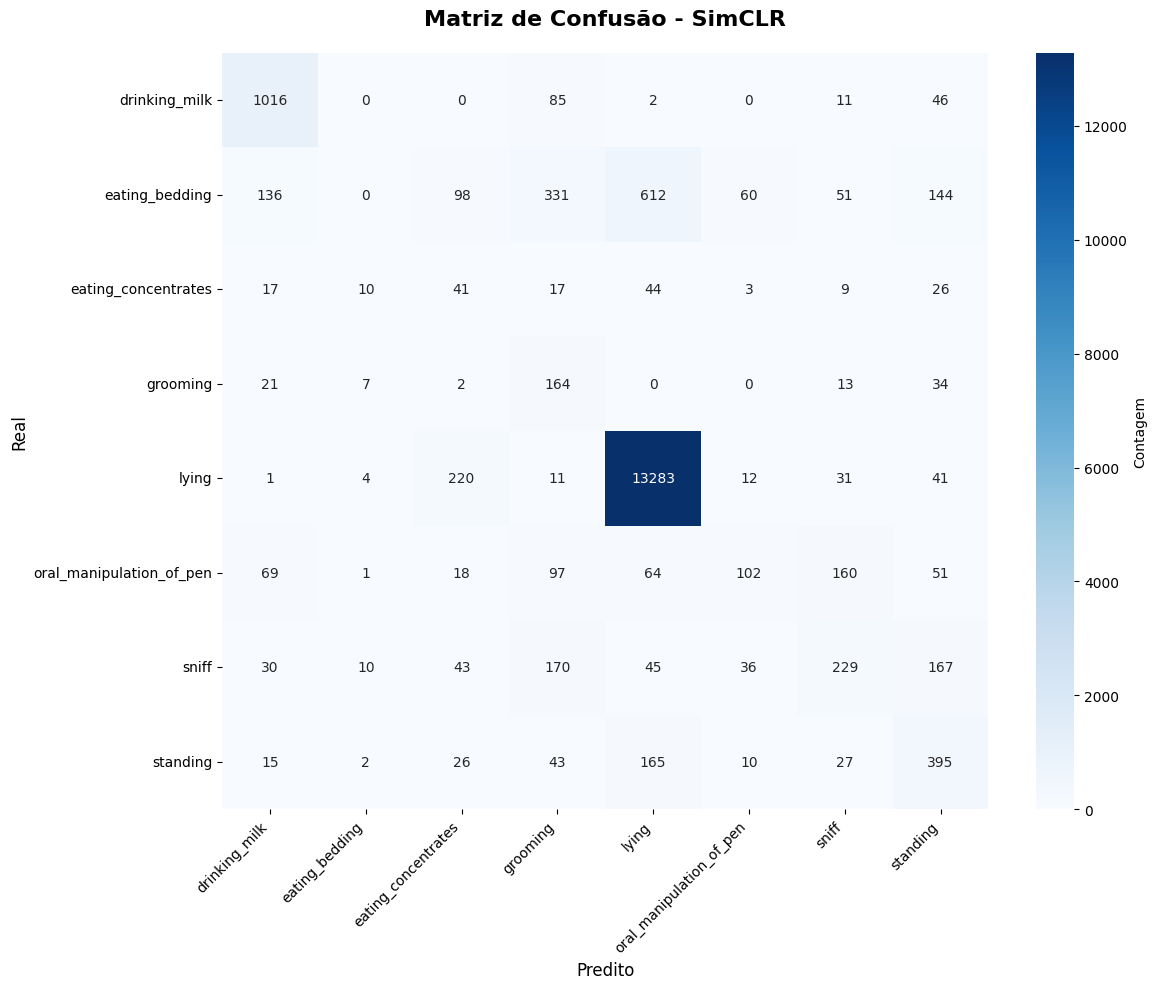

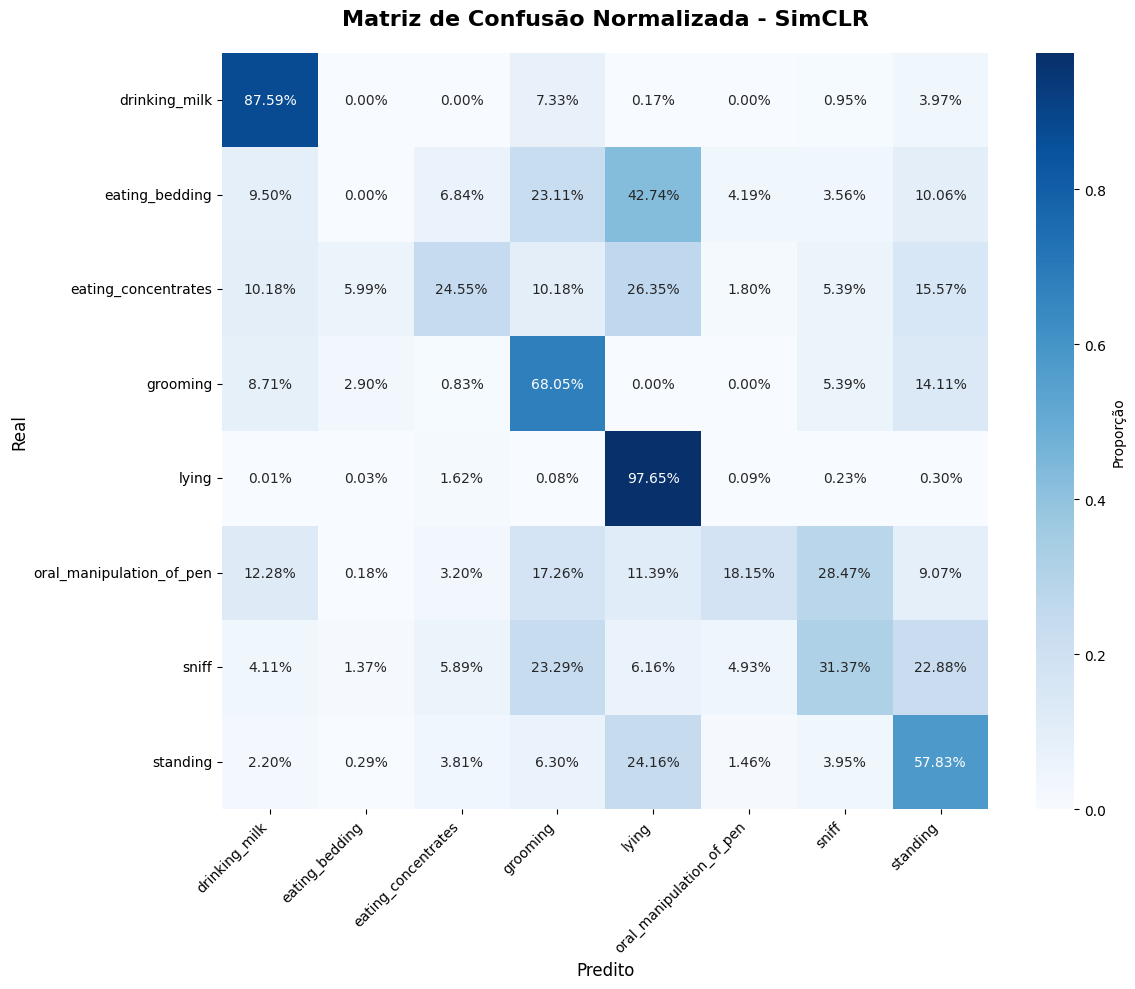

In [17]:
# Matriz de confusão
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Contagem'}
)
plt.title('Matriz de Confusão - SimCLR', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Matriz normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2%',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
    cbar_kws={'label': 'Proporção'}
)
plt.title('Matriz de Confusão Normalizada - SimCLR', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predito', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
# Salvar predições em CSV
predictions_df = pd.DataFrame({
    'timestamp': np.arange(len(all_preds)),
    'real': label_encoder.inverse_transform(all_labels),
    'predicted': label_encoder.inverse_transform(all_preds),
    'correct': all_labels == all_preds
})

# Adicionar probabilidades
for i, class_name in enumerate(label_encoder.classes_):
    predictions_df[f'prob_{class_name}'] = all_probs[:, i]

predictions_df.to_csv('simclr_predictions_test.csv', index=False)
print(f"Predições salvas em 'simclr_predictions_test.csv'")
print(f"\nPrimeiras linhas:")
print(predictions_df.head(10))

Predições salvas em 'simclr_predictions_test.csv'

Primeiras linhas:
   timestamp                 real            predicted  correct  \
0          0  eating_concentrates                sniff    False   
1          1  eating_concentrates                sniff    False   
2          2  eating_concentrates  eating_concentrates     True   
3          3  eating_concentrates             standing    False   
4          4  eating_concentrates             standing    False   
5          5  eating_concentrates             standing    False   
6          6  eating_concentrates             standing    False   
7          7  eating_concentrates                lying    False   
8          8  eating_concentrates                lying    False   
9          9  eating_concentrates                lying    False   

   prob_drinking_milk  prob_eating_bedding  prob_eating_concentrates  \
0            0.014291             0.078773                  0.068690   
1            0.029044             0.176292       

## 8. Visualização de Embeddings (t-SNE) 🎨

Visualizar representações aprendidas pelo encoder

In [19]:
# Extrair embeddings do encoder
classifier.eval()
test_embeddings = []

with torch.no_grad():
    for batch_x, _ in test_supervised_loader:
        batch_x = batch_x.to(device)
        # IMPORTANTE: Transpor antes de passar ao encoder!
        # batch_x vem como (batch, time, channels) e precisa ser (batch, channels, time)
        batch_x = batch_x.transpose(1, 2)
        # Passar pelo encoder apenas
        embeddings = classifier.encoder(batch_x)
        test_embeddings.append(embeddings.cpu().numpy())

test_embeddings = np.vstack(test_embeddings)
print(f"Embeddings shape: {test_embeddings.shape}")

# Aplicar t-SNE
from sklearn.manifold import TSNE

print("Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500)
embeddings_2d = tsne.fit_transform(test_embeddings)

print(f"Embeddings 2D shape: {embeddings_2d.shape}")

Embeddings shape: (18578, 128)
Aplicando t-SNE...
Embeddings 2D shape: (18578, 2)
Embeddings 2D shape: (18578, 2)


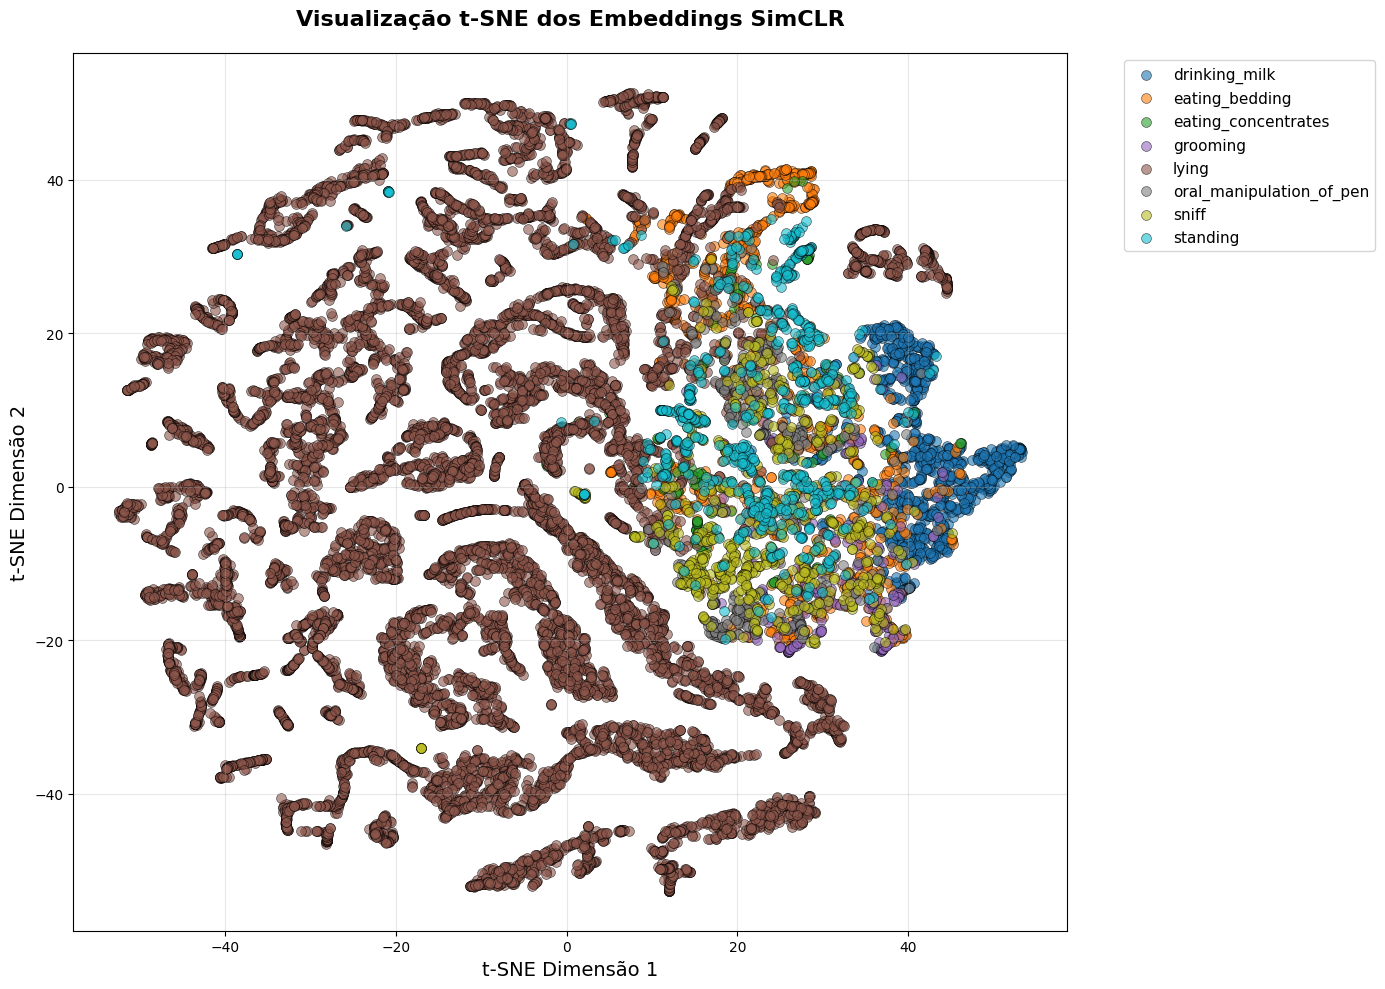

Visualização t-SNE salva em 'tsne_embeddings_simclr.png'


In [20]:
# Plotar t-SNE
fig, ax = plt.subplots(figsize=(14, 10))

# Criar colormap
colors = plt.cm.tab10(np.linspace(0, 1, NUM_CLASSES))

for i, class_name in enumerate(label_encoder.classes_):
    mask = all_labels == i
    ax.scatter(
        embeddings_2d[mask, 0],
        embeddings_2d[mask, 1],
        c=[colors[i]],
        label=class_name,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidths=0.5
    )

ax.set_xlabel('t-SNE Dimensão 1', fontsize=14)
ax.set_ylabel('t-SNE Dimensão 2', fontsize=14)
ax.set_title('Visualização t-SNE dos Embeddings SimCLR', fontsize=16, fontweight='bold', pad=20)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tsne_embeddings_simclr.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualização t-SNE salva em 'tsne_embeddings_simclr.png'")

## 9. Comparação com Baselines 📈

Comparar SimCLR com Random Forest e Neural Network

In [21]:
# Resultados SimCLR
simclr_results = {
    'Model': 'SimCLR',
    'Accuracy': test_acc * 100,
    'F1-Macro': test_f1_macro,
    'F1-Weighted': test_f1_weighted
}

# Criar DataFrame de comparação (adicionar RF e NN manualmente ou ler de CSVs se existirem)
comparison_df = pd.DataFrame([simclr_results])

# Tentar carregar resultados anteriores se existirem
try:
    rf_results = pd.read_csv('resumo_acuracias.csv')
    if 'Random Forest' in rf_results.columns:
        rf_acc = rf_results['Random Forest'].iloc[0] if len(rf_results) > 0 else None
        if rf_acc:
            comparison_df = pd.concat([
                comparison_df,
                pd.DataFrame([{
                    'Model': 'Random Forest',
                    'Accuracy': rf_acc,
                    'F1-Macro': None,
                    'F1-Weighted': None
                }])
            ], ignore_index=True)
except:
    print("Não foi possível carregar resultados do Random Forest")

print("=" * 60)
print("COMPARAÇÃO DE MODELOS")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)

# Salvar comparação
comparison_df.to_csv('model_comparison_simclr.csv', index=False)
print("\nComparação salva em 'model_comparison_simclr.csv'")

COMPARAÇÃO DE MODELOS
 Model  Accuracy  F1-Macro  F1-Weighted
SimCLR 81.978684  0.414568     0.796031

Comparação salva em 'model_comparison_simclr.csv'


## 10. Limpeza de Memória GPU 🧹

In [22]:
# Limpeza de memória
import gc

# Mover modelo para CPU
classifier.cpu()
simclr_model.cpu()

# Deletar variáveis grandes
del train_contrastive_loader, val_contrastive_loader
del train_supervised_loader, val_supervised_loader, test_supervised_loader
del test_embeddings, embeddings_2d

# Forçar coleta de lixo
gc.collect()

# Limpar cache CUDA
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Memória GPU liberada!")
    print(f"Memória alocada: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
    print(f"Memória reservada: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")
else:
    print("GPU não disponível")

print("\n✅ Limpeza concluída!")

Memória GPU liberada!
Memória alocada: 44.49 MB
Memória reservada: 80.00 MB

✅ Limpeza concluída!
